In [22]:
import torch
import numpy
from torch import nn
import pandas as pd
import random
import json
from datetime import datetime
import matplotlib.pyplot as plt

In [10]:
with open('config.json', 'r') as fh:
    config = json.load(fh)
    
#feature_count = len(config['features'])
feature_count = 37

In [11]:
#Function to randomly sample the non/suicidal group windows based on #days
    #Return:
    #sample_encode: combination of non/suicidal randomly sampled encodings
    #sample_lbl: combination of non/suicidal alligned random labels to encodings
def sample_window(suicidal, nonsuicidal, batch_enc, batch_lbl, window=10):
    sample_encode = []
    sample_lbl = []
    
    for i in suicidal:
        valid = False
        while not valid:
        
            index_ls = [i for i, x in enumerate(batch_lbl[i]) if x==1 and i >= (window - 1)] #index of suicidal days

            if not index_ls:
                pos = random.randint(window ,len(batch_lbl[i]) - window - 1)
                index_ls.append(pos)

            rnd_idx = random.randint(0,len(index_ls) - 1) # random generation to choose an index from index_ls
            index = index_ls[rnd_idx] #the index used (this is the label)
            start = index - window - 1 #starting position of the sliding window for this particular survey run
            
            if (batch_enc[i][start:index+1]): break

        sample_lbl.append([batch_lbl[i][index]])
        sample_encode.append(batch_enc[i][start:index+1])
    
    for i in nonsuicidal:
        valid = False
        while not valid:
        
            index_ls = [i for i, x in enumerate(batch_lbl[i]) if x==0 and i >= (window - 1)] #index of suicidal days

            rnd_idx = random.randint(0, len(index_ls) - 1) # random generation to choose an index from index_ls
            index = index_ls[rnd_idx] #the index used (this is the label)
            start = index - window - 1 #starting position of the sliding window for this particular survey run
            
            if (batch_enc[i][start:index+1]): break

        sample_lbl.append([batch_lbl[i][index]])
        sample_encode.append(batch_enc[i][start:index+1])
    
    #shuffle the lists but maintain coallation with the label
    temp = list(zip(sample_encode, sample_lbl))
    random.shuffle(temp)
    shuf_encode, shuf_lbl = zip(*temp)
    shuf_encode, shuf_lbl = list(shuf_encode), list(shuf_lbl)
    
    return shuf_encode, shuf_lbl

#Function to Separate minibatches into non/suicidal groups to equally weigh
#Key Question: Does this oversampling introduce too much bias?
    #inputs:
    #size: minibatch length to divide equally between samples
    #Return:
    #neg: participants with non-suicidal samples
    #pos: participants with suicidal samples
def oversample_classes(size):
    indeces = random_selection(size, size)
    pos = indeces[:int(size/2)]
    neg = indeces[int(size/2):]
    return pos, neg
    

#Random function with no repeats
    #input:
    #num_rnd = total random indeces needed (returned total list size)
    #len_list = size of the list for random to know range for indeces
    #Return:
    #r_list = list of unique random indeces
def random_selection(num_rnd, len_list):
    rlist = []
    for i in range(num_rnd):
        r = random.randint(0, len_list-1)
        while r in rlist: 
            r = random.randint(0, len_list-1)
        rlist.append(r)
    
    return rlist
            

class AutismDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        # loading and preprocessing of ALL the data
        self.encodings = encodings
        self.labels = labels
        #return later and make sure there is an offset
        
    def __getitem__(self, idx):
        # how to process just one example and one label
        example = self.encodings[idx]
        label = self.labels[idx]
        return example, label

    def __len__(self):
        return len(self.labels)

def custom_collate_fn(minibatch):
    batch_examples = list([list(e[0]) for e in minibatch]) #convert encodings to list
    label_examples = list([list(e[1]) for e in minibatch]) #convert labels to list (need to track along with encod)
    
    max_len = max([len(e) for e in batch_examples]) #get the participant with most surveys
    
    mask = [] #setup the mask structure for all participants
    for e in range(len(batch_examples)): #loop through all the participants
        e_mask = [1 for i in range(len(batch_examples[e]))] #initialize this participants individual mask
        while len(batch_examples[e]) < max_len: #looping over the longest number of surveys to mask/pad
            e_mask.append(0) #adding to the mask for the particiapnt
            label_examples[e].append(0) #padding label to track before collating
            batch_examples[e].append([0 for i in range(feature_count)]) #padding the participants survey data
            
        mask.append(e_mask) #adding the participants mask to the entirety of the mask data
    
    #randomly select the 2 classes of participants
    negative, positive = oversample_classes(size=len(label_examples))
    
    #randomly sample x days within the classes
    samp_batch, samp_lbl = sample_window(positive, negative, batch_examples, label_examples, config['window_size'])
    
    batch_examples = [torch.tensor(e) for e in samp_batch] #converting the endcodings to tensors
    batch_labels = [torch.tensor(e).long() for e in samp_lbl] #converting labels to tensors
    
    return (batch_examples, batch_labels, mask)

def validate_collate(minibatch):
    batch_examples = list([list(e[0]) for e in minibatch]) #convert encodings to list
    label_examples = list([list(e[1]) for e in minibatch]) #convert labels to list (need to track along with encod)
    
    

In [12]:
def preprocess_encodings(x, val_participants):
    x = dataframe.loc[:, ('energy_levels','motivation','productivity','illness','food_health',
                                      'physical_activity','leisure_time','negative_feelings','reduce_negativity',
                                      'positive_feelings','increase_positive','enjoy_moment','show_feelings',
                                      'accepting_feelings','fault_feeling','feel_better','feelings_last','stressed',
                                      'stress_amount','stress_management','stress_interference','face_interaction',
                                      'digital_interaction','person_connection','digital_connection',
                                      'desire_interaction','feeling_support','spiritual_connection','number_naps',
                                      'napping_time','days','Response_Gap','Next_Gap',
                                      'suicide_thoughts','Recipient_First_Name','Prescribed_Group')]
    
    x[['stress_amount','stress_management',
       'stress_interference','napping_time']] = x[['stress_amount','stress_management',
                                                   'stress_interference','napping_time']].fillna(value=0)
    x = x.dropna()
    
    x['reduce_negativity'] = x['reduce_negativity'].map({'Yes':1.0,'No':0.0})
    x['increase_positive'] = x['increase_positive'].map({'Yes':1.0,'No':0.0})
    x['enjoy_moment'] = x['enjoy_moment'].map({'Yes':1.0,'No':0.0})
    x['show_feelings'] = x['show_feelings'].map({'Yes':1.0,'No':0.0})
    x['accepting_feelings'] = x['accepting_feelings'].map({'Yes':1.0,'No':0.0})
    x['fault_feeling'] = x['fault_feeling'].map({'Yes':1.0,'No':0.0})
    x['feel_better'] = x['feel_better'].map({'Yes':1.0,'No':0.0})
    x['feelings_last'] = x['feelings_last'].map({'Yes':1.0,'No':0.0})
    x['stressed'] = x['stressed'].map({'Yes':1.0,'No':0.0})
    x['suicide_thoughts'] = x['suicide_thoughts'].map({'Yes':1.0,'No':0.0})
    x = x.drop(['napping_time'], axis=1)
    
    onehot_group = pd.get_dummies(x['Prescribed_Group'])
    x = x.drop(['Prescribed_Group'],axis=1)
    x = x.join(onehot_group)
    
    reshaped = []
    labeled = []
    
    val_enc = []
    val_lbl = []
    for part in x.Recipient_First_Name.unique():
        queried = x.query('Recipient_First_Name==@part')
        
        if part in val_participants:
            val_lbl.append(queried.suicide_thoughts.values[1:])
            queried = queried.drop('Recipient_First_Name',axis=1)
            val_enc.append(queried.values[:-1])
        else:
            labeled.append(queried.suicide_thoughts.values[1:])
            queried = queried.drop('Recipient_First_Name',axis=1)
            reshaped.append(queried.values[:-1])
        
    return reshaped, labeled, val_enc, val_lbl

In [13]:
class LSTMmodel(nn.Module):
    def __init__(self, num_features, hidden_layer_size, num_layers, output_size, bidirectional=False, p_dropout=0.0):
        super().__init__()
           
        self.num_features = num_features
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.output_size = output_size
        self.p_dropout = p_dropout
        self.hidden_layer_size = hidden_layer_size*(int(self.bidirectional)+1)
        self.lstm = nn.LSTM(input_size=self.num_features, hidden_size=hidden_layer_size,
                            num_layers=self.num_layers, batch_first=True, dropout=self.p_dropout,
                            bidirectional=self.bidirectional)

        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_layer_size, self.hidden_layer_size//2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(self.hidden_layer_size//2, self.output_size)
                )

    # 
    def forward(self, x):
        bs, seq_len, _ = x.size()
        hidden_cell = self.reset_forward(bs, x.device)
        output, _ = self.lstm(x, hidden_cell)
        final_hidden_representation = output[:,-1]
        out = self.classifier(final_hidden_representation)
        return out

    # Function to reset the initial vector to 0's -> we don't want to muddy up the classification
    def reset_forward(self, bs, device='cpu'):
        return (torch.zeros((1+self.bidirectional)*self.num_layers,bs,int(self.hidden_layer_size/(1+self.bidirectional))).float().to(device),
                torch.zeros((1+self.bidirectional)*self.num_layers,bs,int(self.hidden_layer_size/(1+self.bidirectional))).float().to(device))

In [14]:
def run_LSTM():
    lstm = LSTMmodel(num_features=feature_count, hidden_layer_size=128, num_layers=1, output_size=2, bidirectional=True, p_dropout=0)

    loss_function = torch.nn.CrossEntropyLoss()
    rate_learning = 1e-4
    optim = torch.optim.Adam(lstm.parameters(), lr=rate_learning, weight_decay=1e-3)

    epochs = 100

    for e in range(epochs):
        running_loss = 0

        for encoding, label, mask in train_loader:
            output = lstm(torch.stack(encoding).float())
            loss = loss_function(output, torch.cat(label).long()) #if i pull out the 'labels' here...what can I replace it with?

            optim.zero_grad()
            loss.backward()
            optim.step()
            running_loss += float(loss)
            
    testset = AutismDataset(validation_encoding, validation_lables)
    testloader = torch.utils.data.DataLoader(dataset,collate_fn=custom_collate_fn,shuffle=True,batch_size=5)

    torch.save({'state_dict': lstm.state_dict(),
                        'optimizer' : optim.state_dict(),
                       }, 'first_model.pth')

    dataiter = iter(testloader)
    test_encodings, test_labels, test_mask = next(dataiter)

    outputs = lstm(torch.stack(test_encodings).float())

    _, predicted = torch.max(outputs, 1)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels, mask = data
            outputs = lstm(torch.stack(images).float())
            _, predicted = torch.max(outputs.data, 1)
            total += torch.tensor(labels).size(0)
            labels = torch.cat(labels).long()
            #print('prediction')
            #print(predicted)
            #print('label')
            #print(labels)
            correct += float((predicted == labels).sum().item())

    print('Accuracy of the network: %f %%' % (
        100 * correct / total))
    
    return (100 * correct / total)

In [15]:
def sample_participants(x):
    names = x.Recipient_First_Name.unique()
    sampling = random.sample(list(names),3)
    return sampling


In [16]:
#loop through samples:
accuracies = []
samples = []
dataframe = pd.read_csv(config['data'])
for i in range(config['validation_loop']):
    samp = sample_participants(dataframe)
    samples.append(samp)
    encodings, labels, validation_encoding, validation_lables = preprocess_encodings(dataframe,samp)
    dataset = AutismDataset(encodings,labels)
    train_loader = torch.utils.data.DataLoader(dataset,collate_fn=custom_collate_fn,shuffle=True,batch_size=5)
    
    accuracies.append(run_LSTM())

Accuracy of the network: 75.000000 %
Accuracy of the network: 86.250000 %
Accuracy of the network: 79.746835 %
Accuracy of the network: 89.873418 %
Accuracy of the network: 82.278481 %
Accuracy of the network: 73.417722 %
Accuracy of the network: 86.075949 %
Accuracy of the network: 86.075949 %
Accuracy of the network: 73.417722 %
Accuracy of the network: 87.500000 %
Accuracy of the network: 83.544304 %
Accuracy of the network: 81.250000 %
Accuracy of the network: 89.873418 %
Accuracy of the network: 84.810127 %
Accuracy of the network: 82.500000 %
Accuracy of the network: 81.012658 %
Accuracy of the network: 88.607595 %
Accuracy of the network: 86.075949 %
Accuracy of the network: 82.500000 %
Accuracy of the network: 86.075949 %


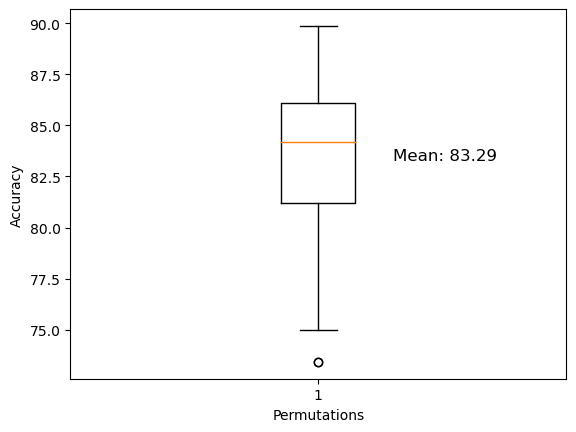

<Figure size 640x480 with 0 Axes>

In [36]:
now = datetime.today()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S-%f")
output_frame = pd.DataFrame(data={'Validation_Participants': samples, 'Accuracies': accuracies})

plt.boxplot(accuracies)
plt.xlabel("Permutations")
plt.ylabel("Accuracy")
mean_accuracy = numpy.mean(accuracies)
plt.text(1.15, mean_accuracy, f"Mean: {mean_accuracy:.2f}", fontsize=12)
plt.show()

plt.savefig('output/' + timestamp_str + '_boxplot.png')
output_frame.to_csv('output/' + timestamp_str + '_run_data.csv')